In [1]:
import os
import os.path as osp
import shutil
import meshio
from typing import List

import logging
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv
import numpy as np
import scipy.sparse as sp
import tqdm

from mesh_handler import xdmf_to_meshes, meshes_to_xdmf, vtu_to_mesh, mesh_to_vtu, accessing_mesh_data, create_mock_mesh, get_geometric_data, get_surface

# Demo mock data

In [2]:
# DEMO
print("\n### DEMO  XDMF ARCHIVE ###")
print("2D mesh archive:")
xdmf_path = osp.join(os.getcwd(), "Obstacle.xdmf")
meshes = xdmf_to_meshes(xdmf_path)
meshes[0].points


### DEMO  XDMF ARCHIVE ###
2D mesh archive:
Loaded 121 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\Obstacle.xdmf



array([[0.      , 0.      , 0.      ],
       [4.      , 0.      , 0.      ],
       [4.      , 3.      , 0.      ],
       ...,
       [2.20449 , 0.663779, 0.      ],
       [3.82059 , 2.75713 , 0.      ],
       [0.736707, 0.299932, 0.      ]], shape=(1632, 3), dtype=float32)

In [3]:
accessing_mesh_data(meshes[10])

There are 1632 nodes in this mesh.
First 5 nodes of the mesh: 
[[0.  0.  0. ]
 [4.  0.  0. ]
 [4.  3.  0. ]
 [0.  3.  0. ]
 [0.  2.9 0. ]] 

Types of cells in the mesh: ['triangle']
There are 3122 triangular cells in this mesh.
First 5 triangular cells of the mesh: 
[[ 696 1561  561]
 [ 642  252 1464]
 [ 252  605 1464]
 [ 275  652 1555]
 [1322  664  604]] 

Feature name: Vitesse / Feature shape: (1632, 3)
Feature name: Pression / Feature shape: (1632,)


In [4]:
print("\n3D mesh archive:")
xdmf_path = osp.join(os.getcwd(), "AllFields_Resultats_MESH_1.xdmf")
meshes = xdmf_to_meshes(xdmf_path)
accessing_mesh_data(meshes[10])


3D mesh archive:
Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\AllFields_Resultats_MESH_1.xdmf

There are 11446 nodes in this mesh.
First 5 nodes of the mesh: 
[[-2.205367   4.560882   1.67214  ]
 [-2.2580128  4.7989006  1.8012575]
 [-2.212806   5.078872   1.8893555]
 [-2.0400388  5.2704096  1.920871 ]
 [-1.8397863  5.4581513  1.9444325]] 

Types of cells in the mesh: ['tetra']
There are 55472 tetrahedral cells in this mesh.
First 5 tetrahedral cells of the mesh: 
[[4803 4804 4805 4806]
 [4807    0 2921 2922]
 [4808 1941 4809 4810]
 [4811 4812 4813 4814]
 [4815 3583 4816    3]] 

Feature name: Vitesse / Feature shape: (11446, 3)
Feature name: Pression / Feature shape: (11446,)


In [5]:
mesh = meshes[0]
mesh.cells_dict['tetra']

array([[4803, 4804, 4805, 4806],
       [4807,    0, 2921, 2922],
       [4808, 1941, 4809, 4810],
       ...,
       [6558, 6354, 6587, 6804],
       [6176, 6908, 9039, 6943],
       [6176, 5669, 7795, 6178]], shape=(55472, 4))

In [6]:
def get_neighbors(mesh, cell_idx):
    neighbors = set()
    for i, cell in enumerate(mesh.cells_dict['tetra']):
        if cell_idx in cell:
            # the cell is in this tetrahedron
            for j in cell:
                if j != cell_idx:
                    neighbors.add(j.item())
    return neighbors

mesh = meshes[0]
get_neighbors(mesh, 50)

{49, 51, 801, 3253, 3433, 3434, 6748, 9626, 10349}

In [7]:
print("\n### DEMO  VTU FILE FORMAT ###")
mock_mesh = create_mock_mesh()
vtu_path = osp.join(os.getcwd(), "mock_mesh.vtu")
mesh_to_vtu(mock_mesh, vtu_path)


### DEMO  VTU FILE FORMAT ###
Mock mesh created.
Mesh saved to c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\mock_mesh.vtu


# Real data

In [8]:
xdmf_path = osp.join(os.getcwd(), "4Students_AnXplore03/AllFields_Resultats_MESH_1.xdmf")
meshes = xdmf_to_meshes(xdmf_path)
accessing_mesh_data(meshes[10])

Loaded 80 timesteps from AllFields_Resultats_MESH_1.xdmf

There are 11446 nodes in this mesh.
First 5 nodes of the mesh: 
[[-2.205367   4.560882   1.67214  ]
 [-2.2580128  4.7989006  1.8012575]
 [-2.212806   5.078872   1.8893555]
 [-2.0400388  5.2704096  1.920871 ]
 [-1.8397863  5.4581513  1.9444325]] 

Types of cells in the mesh: ['tetra']
There are 55472 tetrahedral cells in this mesh.
First 5 tetrahedral cells of the mesh: 
[[4803 4804 4805 4806]
 [4807    0 2921 2922]
 [4808 1941 4809 4810]
 [4811 4812 4813 4814]
 [4815 3583 4816    3]] 

Feature name: Vitesse / Feature shape: (11446, 3)
Feature name: Pression / Feature shape: (11446,)


# Create train dataset t to t+1

In [22]:
def build_data():
    """
    Creates a dataset with the following structure:
    - features: list of Data objects containing the features at time t-1
        graph.x : [N x 7] (x, y, z, vx, vy, vz, p)
    - target: list of Data objects containing the features at time t
        graph.x : [N x 7] (x, y, z, vx, vy, vz, p)
    """
    data = {
        'features' : [],
        'target' : []
    }
    list_files = os.listdir(osp.join(os.getcwd(), "4Students_AnXplore03"))
    list_files = [f for f in list_files if f.endswith('.xdmf')]

    for f in tqdm.tqdm(list_files[:-1]):
        # print("\n\n New file:\n")
        xdmf_path = osp.join(os.getcwd(), "4Students_AnXplore03", f)
        meshes = xdmf_to_meshes(xdmf_path, verbose=False)
        mesh = meshes[0]

        edge_index, edge_attr = get_geometric_data(mesh)

        for time_step in range(2, len(meshes)):
            # Create node features (x, y, z, vx, vy, vz, p)
            node_features_1 = np.hstack([
                meshes[time_step-1].points,
                meshes[time_step-1].point_data['Vitesse'],
                meshes[time_step-1].point_data['Pression'].reshape(-1, 1)
            ]) # Shape: (num_nodes, 7)
            node_features_1 = torch.tensor(node_features_1, dtype=torch.float)
            node_features = np.hstack([
                meshes[time_step].points,
                meshes[time_step].point_data['Vitesse'],
                meshes[time_step].point_data['Pression'].reshape(-1, 1)
            ]) # Shape: (num_nodes, 7)
            node_features = torch.tensor(node_features, dtype=torch.float)

            # Create PyTorch Geometric data object
            graph_data_1 = Data(x=node_features_1, edge_index=edge_index, edge_attr=edge_attr)
            graph_data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr)

            data['features'].append(graph_data_1)
            data['target'].append(graph_data)
    return data

In [10]:
data = build_data()

100%|██████████| 102/102 [01:03<00:00,  1.60it/s]


In [14]:
data['features'][0]

Data(x=[11446, 7], edge_index=[2, 110854], edge_attr=[110854, 3])

In [15]:
data['target'][0]

Data(x=[11446, 7], edge_index=[2, 110854], edge_attr=[110854, 3])

In [16]:
data.keys()

dict_keys(['features', 'target'])

In [17]:
# get length of the data
len(data['features'])

7956

# Create test dataset t and t+1 to t+2 + limit conditions

In [18]:
xdmf_path = osp.join(os.getcwd(), "4Students_AnXplore03/AllFields_Resultats_MESH_1.xdmf")
meshes = xdmf_to_meshes(xdmf_path)
mesh = meshes[0]
surface = get_surface(mesh)
surface

Loaded 80 timesteps from AllFields_Resultats_MESH_1.xdmf



array([1., 1., 1., ..., 0., 0., 0.], shape=(11446,))

In [21]:
def build_data_two():
    """
    Creates a dataset with the following structure:
    - features: list of Data objects containing the features at time t-2 and t-1
        graph.x : [N x 16] (x, y, z, vx, vy, vz, p, S, x, y, z, vx, vy, vz, p, S)
        S is a boolean indicating if the point is on the surface (limit condition)
    - target: list of Data objects containing the features at time t
        graph.x : [N x 8] (x, y, z, vx, vy, vz, p, S)
    """
    data = {
        'features' : [],
        'target' : []
    }
    list_files = os.listdir(osp.join(os.getcwd(), "4Students_AnXplore03"))
    list_files = [f for f in list_files if f.endswith('.xdmf')]

    for f in tqdm.tqdm(list_files[:-1]):
        # print("\n\n New file:\n")
        xdmf_path = osp.join(os.getcwd(), "4Students_AnXplore03", f)
        meshes = xdmf_to_meshes(xdmf_path, verbose=False)
        mesh = meshes[0]
        surface = get_surface(mesh)
        edge_index, edge_attr = get_geometric_data(mesh)

        for time_step in range(2, len(meshes)):
            # Create node features (x, y, z, vx, vy, vz, p)
            node_features_2 = np.hstack([
                meshes[time_step-2].points,
                meshes[time_step-2].point_data['Vitesse'],
                meshes[time_step-2].point_data['Pression'].reshape(-1, 1),
                surface.reshape(-1, 1)
            ]) # Shape: (num_nodes, 7)
            node_features_2 = torch.tensor(node_features_2, dtype=torch.float)
            node_features_1 = np.hstack([
                meshes[time_step-1].points,
                meshes[time_step-1].point_data['Vitesse'],
                meshes[time_step-1].point_data['Pression'].reshape(-1, 1),
                surface.reshape(-1, 1)
            ]) # Shape: (num_nodes, 7)
            node_features_1 = torch.tensor(node_features_1, dtype=torch.float)
            node_features = np.hstack([
                meshes[time_step].points,
                meshes[time_step].point_data['Vitesse'],
                meshes[time_step].point_data['Pression'].reshape(-1, 1),
                surface.reshape(-1, 1)
            ]) # Shape: (num_nodes, 7)
            node_features = torch.tensor(node_features, dtype=torch.float)

            # Create PyTorch Geometric data object
            # concat data at t-2 and t-1
            graph_data_features = Data(
                x=torch.cat((node_features_2, node_features_1), 1),
                edge_index=edge_index,
                edge_attr=edge_attr
            )
            graph_data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr)

            data['features'].append(graph_data_features)
            data['target'].append(graph_data)
    return data

In [20]:
data_two = build_data_two()

100%|██████████| 102/102 [01:30<00:00,  1.12it/s]


In [23]:
data_two['features'][0]

Data(x=[11446, 16], edge_index=[2, 110854], edge_attr=[110854, 3])

In [24]:
data_two['target'][0]

Data(x=[11446, 8], edge_index=[2, 110854], edge_attr=[110854, 3])

In [25]:
data_two.keys()

dict_keys(['features', 'target'])

In [26]:
len(data_two['features'])

7956

# Predict only zero to compare to a baseline

In [27]:
from models.ZeroPredictor import ZeroPredictor

In [38]:
model = ZeroPredictor()
xdmf_path = osp.join(os.getcwd(), "4Students_AnXplore03", "AllFields_Resultats_MESH_219.xdmf")
meshes = xdmf_to_meshes(xdmf_path)
total_error, list_errors = model.test_model(meshes)

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_219.xdmf

Total error: 2.6491


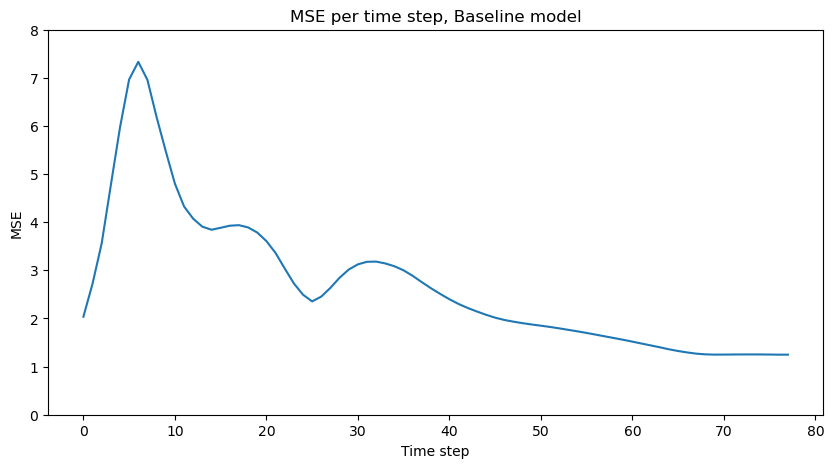

In [39]:
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.figure(figsize=(10, 5))

plt.plot(np.array(list_errors, dtype=np.float32))
plt.ylim(0, 8)
plt.xlabel("Time step")
plt.ylabel("MSE")
plt.title("MSE per time step, Baseline model")
plt.savefig("MSE_per_time_step.png")
plt.savefig("MSE_per_time_step.png")
plt.show()

# Message passing model, t to t+1

In [30]:
from models.GNNPredictor import GNNPredictor

In [31]:
dataset = [
    (data['features'][i], data['target'][i])
    for i in range(100) # use only the first 100 time steps for computational reasons
    # for i in range(len(data['features']))
]

# Create a DataLoader with batch support
batch_size = 16
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Instantiate Model and Optimizer
model = GNNPredictor()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

c:\miniconda\envs\idsc_challenge_jan\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [32]:
# Train the model
model.train_model(loader, optimizer, epochs=10)

# Save model
torch.save(model.state_dict(), "trained_models/gnn_model_small_data_10_epochs.pth")

print("Training complete!")

 10%|█         | 1/10 [00:13<02:04, 13.79s/it]

Epoch 0 | Loss: 4509480.5039


100%|██████████| 10/10 [01:20<00:00,  8.09s/it]

Training complete!


In [41]:
# load model from gnn_model.pth file
model = GNNPredictor()
model.load_state_dict(torch.load("trained_models/gnn_model_small_data_10_epochs.pth"))
xdmf_path = osp.join(os.getcwd(), "4Students_AnXplore03", "AllFields_Resultats_MESH_219.xdmf")
meshes = xdmf_to_meshes(xdmf_path)
total_error, list_errors = model.test_model(meshes)

C:\Users\alexi\AppData\Local\Temp\ipykernel_43540\485948237.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("trained_models/gnn_model_sm

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_219.xdmf

Total error: 2.1814


In [42]:
# debug code for some error I honestly didn't understand that made the kernel crash
# import os
# import matplotlib
# import shutil

# cache_dir = matplotlib.get_cachedir()
# shutil.rmtree(cache_dir)

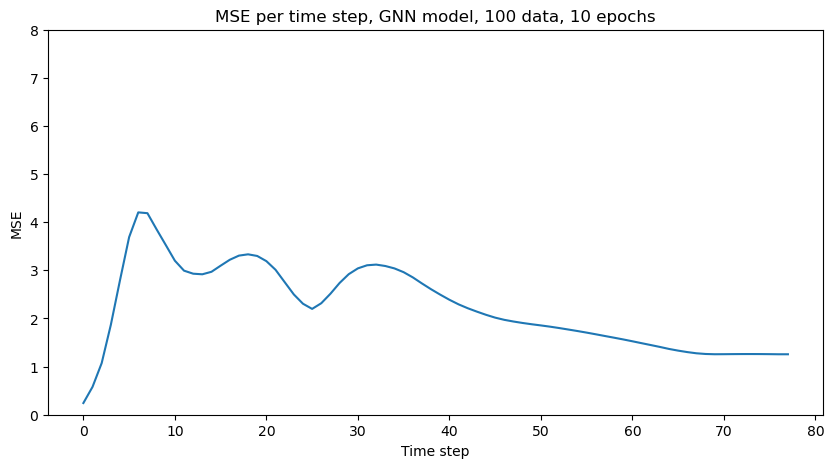

In [43]:
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.figure(figsize=(10, 5))

plt.plot(np.array(list_errors, dtype=np.float32))
plt.ylim(0, 8)
plt.xlabel("Time step")
plt.ylabel("MSE")
plt.title("MSE per time step, GNN model, 100 data, 10 epochs")
plt.savefig("MSE_per_time_step.png")
plt.show()

# Message passing model with RNN (RecurrentGNN)

In [44]:
from models.RecurrentGNN import RecurrentGNN

In [45]:
dataset = [
    (data['features'][i], data['target'][i])
    for i in range(20) # use only the first 100 time steps for computational reasons
    # for i in range(len(data['features']))
]

# Create a DataLoader with batch support
batch_size = 16
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Instantiate Model and Optimizer
model = RecurrentGNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [46]:
# Train the model
model.train_model(loader, optimizer, epochs=10)

# Save model
torch.save(model.state_dict(), "trained_models/recurrent_gnn_model_small_data_10_epochs.pth")

print("Training complete!")

 10%|█         | 1/10 [01:10<10:30, 70.08s/it]

Epoch 0 | Loss: 4602157.6250


100%|██████████| 10/10 [10:45<00:00, 64.57s/it]


Training complete!


In [47]:
# load model from gnn_model.pth file
model = RecurrentGNN()
model.load_state_dict(torch.load("trained_models/recurrent_gnn_model_small_data_10_epochs.pth", weights_only=True))
xdmf_path = osp.join(os.getcwd(), "4Students_AnXplore03", "AllFields_Resultats_MESH_219.xdmf")
meshes = xdmf_to_meshes(xdmf_path)
total_error, list_errors = model.test_model(meshes)

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_219.xdmf

Total error: 2.6015


In [48]:
# debug code for some error I honestly didn't understand that made the kernel crash
# import os
# import matplotlib
# import shutil

# cache_dir = matplotlib.get_cachedir()
# shutil.rmtree(cache_dir)

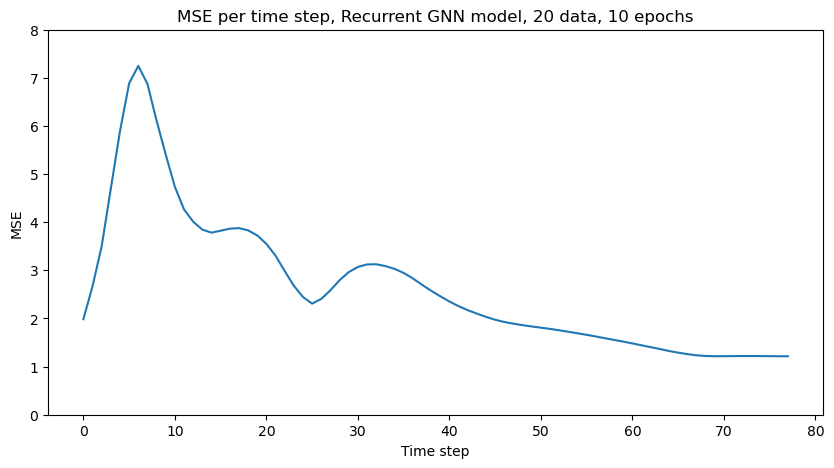

In [49]:
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.figure(figsize=(10, 5))

plt.plot(np.array(list_errors, dtype=np.float32))
plt.ylim(0, 8)
plt.xlabel("Time step")
plt.ylabel("MSE")
plt.title("MSE per time step, Recurrent GNN model, 20 data, 10 epochs")
plt.savefig("MSE_per_time_step.png")
plt.show()

# Message passing model with RNN and two time steps (RecurrentDoubleGNN)

In [16]:
from models.RecurrentDoubleGNN import RecurrentDoubleGNN

In [21]:
dataset = [
    (data_two['features'][i], data_two['target'][i])
    for i in range(20) # use only the first 100 time steps for computational reasons
    # for i in range(len(data['features']))
]

# Create a DataLoader with batch support
batch_size = 16
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Instantiate Model and Optimizer
model = RecurrentDoubleGNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [22]:
# Train the model
model.train_model(loader, optimizer, epochs=5)

# Save model
torch.save(model.state_dict(), "trained_models/recurrent_double_gnn_model_5_epochs.pth")

print("Training complete!")

 20%|██        | 1/5 [01:10<04:41, 70.27s/it]

Epoch 0 | Loss: 3391176.0000


100%|██████████| 5/5 [05:30<00:00, 66.11s/it]


Training complete!


In [26]:
# load model from gnn_model.pth file
model = RecurrentDoubleGNN()
model.load_state_dict(torch.load("trained_models/recurrent_double_gnn_model_5_epochs.pth", weights_only=True))
xdmf_path = osp.join(os.getcwd(), "4Students_AnXplore03", "AllFields_Resultats_MESH_219.xdmf")
meshes = xdmf_to_meshes(xdmf_path)
total_error, list_errors = model.test_model(meshes)

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_219.xdmf



100%|██████████| 78/78 [03:22<00:00,  2.60s/it]


Total error: 2.6404


In [ ]:
# debug code for some error I honestly didn't understand that made the kernel crash
# import os
# import matplotlib
# import shutil

# cache_dir = matplotlib.get_cachedir()
# shutil.rmtree(cache_dir)

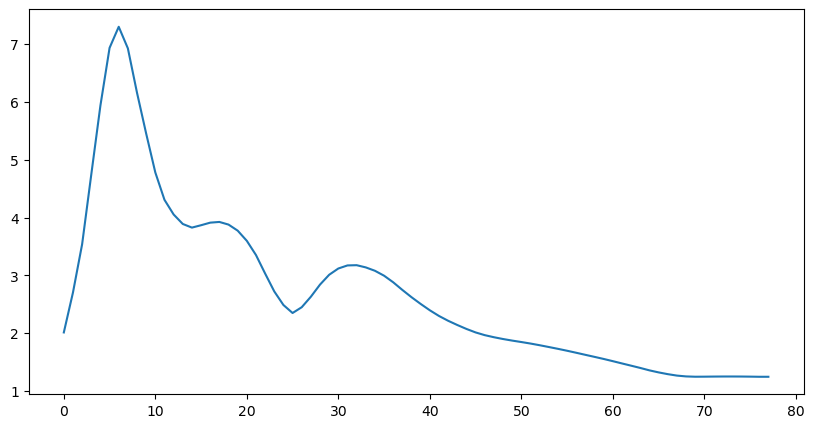

In [ ]:
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.figure(figsize=(10, 5))

plt.plot(np.array(list_errors, dtype=np.float32))
plt.ylim(0, 8)
plt.xlabel("Time step")
plt.ylabel("MSE")
plt.title("MSE per time step, Recurrent Double GNN model, 20 data, 5 epochs")
plt.savefig("MSE_per_time_step.png")
plt.show()